#Práctica: Evaluación y kNN
*Máster en Ciencia de Datos y Aprendizaje Automático - Universidad de La Rioja*

Durante el desarrollo de esta práctica, resuelve los ejercicios en este cuaderno justo después de ser propuestos.

Se valorará positivamente la documentación en las respuestas y la explicación de las mismas.

No olvides guardar tus versiones intermedias en GitHub (menú "Archivo" >> "Guardar una copia en GitHub") y la definitiva antes de la fecha límite de entrega.

Esta sesión práctica se divide en cuatro secciones de distinta complejidad.

* En la primera se explica la primera parte de evaluación en la cual se ve cómo usando la libreria *Scikit-Learn* se pueden separar los conjuntos de training y de testing.

* En la segunda sección, y antes de continuar con la evaluación, es necesario tener un modelo, y para esta sesión vamos a usar el modelo kNN que hemos explicado ya en teoría. En este apartado veremos como se usa y que parámetros son susceptibles de cambio para obtener un resultado más óptimo.

* En la tercera sección, se ven las diferentes estrategias de validación.

* En la última parte se habla de como calcular las métricas que más se usan.

Bibliografía:
* https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python/
* Wine-Quality Dataset: https://archive.ics.uci.edu/dataset/186/wine+quality
* Sklearn metrics: https://scikit-learn.org/stable/modules/model_evaluation.html
* K-nn: https://es.wikipedia.org/wiki/K_vecinos_m%C3%A1s_pr%C3%B3ximos

## Evaluación (parte I)

Evaluar la capacidad predictiva de un modelo consiste en comprobar cómo de próximas son sus predicciones a los verdaderos valores de la variable respuesta. Para poder cuantificarlo de forma correcta, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto", es decir, que no hayan participado en su ajuste. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de test. El tamaño adecuado de las particiones depende en gran medida de la cantidad de datos disponibles y la seguridad que se necesite en la estimación del error, 80%-20% suele dar buenos resultados. El reparto debe hacerse de forma aleatoria o aleatoria-estratificada como se ha explicado en clase.

Además más adelante veremos como también necesitaremos dividir nuestro conjunto de datos en 3 partes: conjunto de entrenamiento, de test y de validación. Aunque ahora no necesitamos explicitamente estos tres grupos si que veremos como se crean.



### Obtenemos los datos

Primero cargamos las librerías que utillizaremos tanto para manejar los datos como crear gráficos.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

#esto determina como queremos que sean los gráficos
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

El conjunto de datos que vamos a usar es "*Wine Quality*", puedes ver más información [aquí](https://archive.ics.uci.edu/ml/datasets/wine+quality).

Cargamos el archivo usando pandas. Este archivo contiene 1599 instancias sobre vinos. Cada instancia viene descrita por 11 características y una última variable que determina la calidad a la que pertenece el vino. Esta variable toma un valor natural entre 1 y 8.

In [3]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')

Revisamos el contenido del archivo, para comprobar que datos son los que tenemos y cómo son.

In [4]:
# Mostrar las n primeras filas del dataset
print(df.head(4))
# Comprobamos la dimensión del dataset
print(df.shape)
# Obtenemos el tipo de cada una de sus características
df.info()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
(1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Colum

Viendo la dimensión del dataset comprobamos que disponemos de 1599 instancias con 12 descriptores (características) cada una.

### Preprocesamos los datos

En esta asignatura no nos vamos a detener mucho en este punto, pero hay casos en los que es necesario hacer un poco de procesamiento como en este ejemplo.

Como variable objetivo, utilizaremos la calidad del vino.

Antes de hacer cualquier cosa sobre los datos hay que ver como son y conocorlos. Para ello vamos a describir los datos para cada característica.

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Otra opción es ver en una gráfica las características para poder observar como son. En este caso, usaremos histogramas y gráficas de densidad para ver la frecuencia de los datos de cada característica.

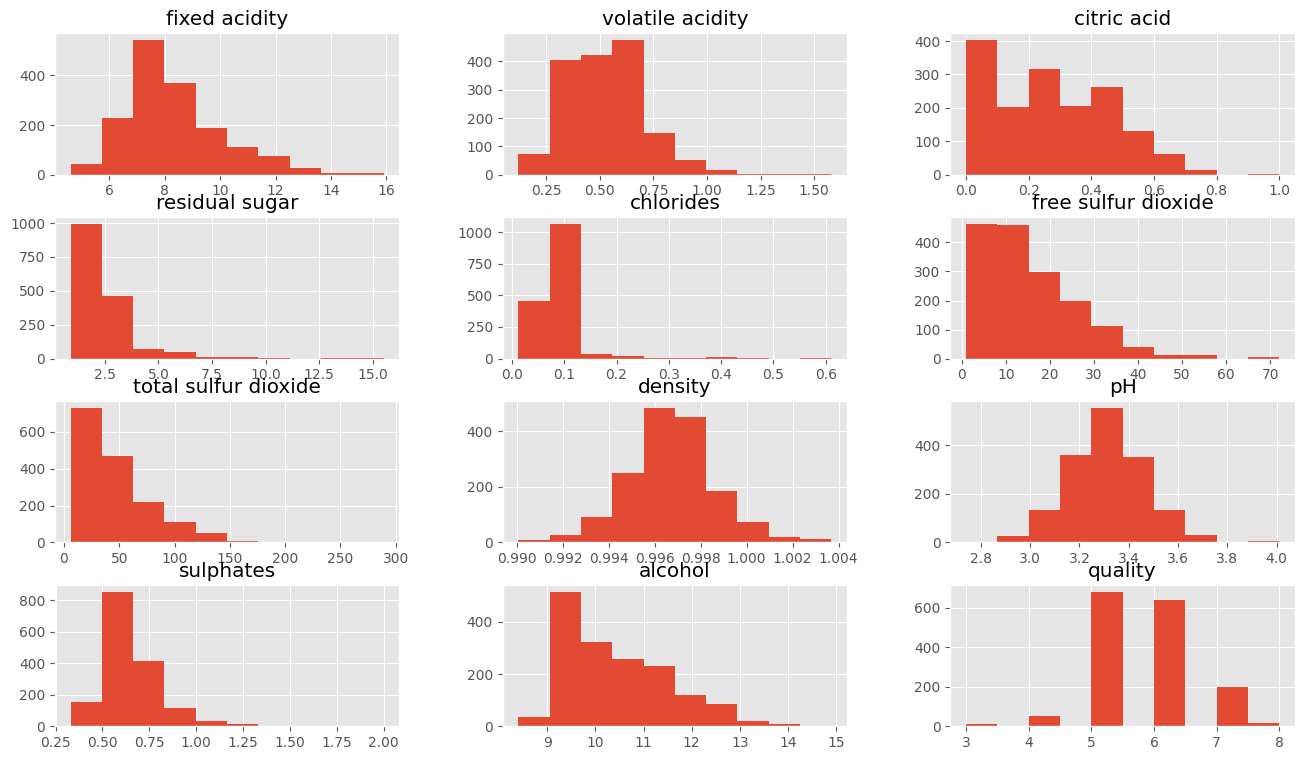

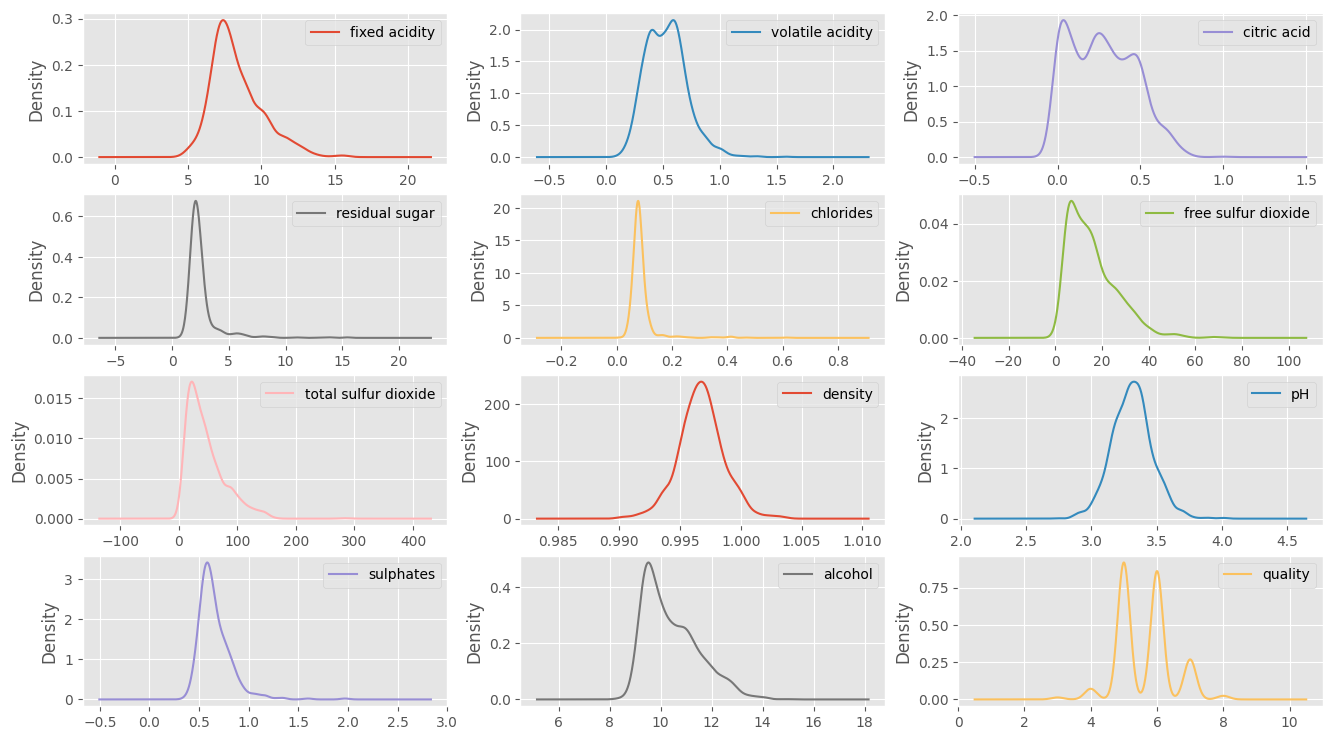

In [6]:
# Histograms
df.hist()
plt.show()

# Density
df.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

Las conclusiones que podemos sacar es que en la mayoría de las características los datos están acumulados en los valores más pequeños, sin embargo características como el *alcohol* o el *pH* tienen más forma de campana.

Esto nos ayuda a observar como son las características dentro de mi conjunto de datos. En este caso sobretodo, nos vamos a fijar en que las *features* no pertenecen a la misma escala y en la variable objetivo



EJERCICIO: ¿qué conclusión obtienes para la variable objetivo?
Una ayuda puede ser agrupar los valores y ver cuantos hay de cada clase de forma numérica. Muestra el valor de instancias para cada clase.

In [7]:
df['quality'].value_counts().sort_index()

,count
quality,
3,10
4,53
5,681
6,638
7,199
8,18


RESPUESTA: Podemos observar que la variable "quality" es discreta, y toma valores enteros entre 3 y 8. La mayoría de los vinos tienen una calidad de 5 o 6, y, en comparación, muy pocos tienen calidad menor o igual que 4 o mayor o igual que 7. Por lo tanto, la distribución de la variable objetivo está desequilibrada, lo que será importante tener en cuenta al entrenar modelos de clasificación, ya que puede balanceo o ponderación de clases.

Para continuar, vamos a abordar el problema como un problema de clasificación binario, de esta manera salvamos la desigualdad entre las clases. Para ello, vamos a dividir las instancias en "good" o "bad" en función de la calidad del vino, considerando que los vinos que estén entre (5,8] serán "good" (toma valor 1) y los de calidad menor o igual que 5, serán "bad" (toma valor 0).

In [8]:
from sklearn.preprocessing import LabelEncoder
# Dividir las instancias del vino como 'good' y 'bad' a partir de la característica "quality"
bins = (2, 5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)
# Asignamos una etiqueta a "quality"
label_quality = LabelEncoder()
# Bad tomará el valor 0 y good será el valor 1
df['quality'] = label_quality.fit_transform(df['quality'])
print(df['quality'].value_counts())


quality
1    855
0    744
Name: count, dtype: int64


EJERCICIO: ¿Se ha corregido el problema que veíamos antes en la variable objetivo?
¿Qué crees que hubiera pasado si hubiéramos considerado como buenos los vinos de calidad mayor que 6?

In [9]:
# Calculamos porcentajes
df['quality'].value_counts(normalize=True) * 100

,proportion
quality,
1,53.470919
0,46.529081


RESPUESTA: Podemos concluir que se ha arreglado el problema de desequilibrio que veíamos antes, ya que ahora tenemos aproximadamente un 53% de vinos buenos contra un 47% de vinos malos, por lo que los modelos de clasificación podrán aprender sin sesgo fuerte hacia una sola clase. Si hubiéramos considerado como buenos los vinos de calidad mayor que 6, observando la distribución de la variable original, habríamos obtenido una cantidad mucho mayor de vinos malos (algo más de 1300) respecto al número de vinos buenos (no llegaría a 250), por lo que no habríamos arreglado el problema de desequilibrio.

Vamos a continuar con el ejemplo y con el conjunto de datos tal y como está.


Cargamos las librerías que vamos a necesitar para, primero separar nuestros datos en grupos: entrenamineto, validación y testeo.


También añadimos la librería para escalar los datos, ya que, aunque no vamos a hacer un preprocesamiento exhaustivo, si que es necesario preprocesar un poco.

Como hemos podido observar a la hora de mostrar las n-primeras instancias del dataset, las características tienen magnitudes muy distintas, y por esta razón es preferible tener los datos normalizados.



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

En la librería *sklearn.preprocessing* hay distintos métodos para escalar los datos, entre ellos:


*   teniendo en cuenta el mínimo y el máximo (*MinMaxScaler*)
*   estandarizando, obteniendo un conjunto de datos de media 0 y desviación estándar 1 (*StandardScaler*)

Para este ejemplo vamos a usar *StandardScaler*.


¡OJO! Antes de escalar los datos hay que separarlos.

Si no los separamos antes de escalar estaríamos usando en cierto modo los datos de entrenamiento para testeo y eso **no** puede ser.



Recuerda que antes de separar el dataset en un conjunto para entrenar y otro para testear, tenemos que separar el conjunto de datos original de tal manera que tengamos los descriptores por un lado (X) y el valor objetivo (o clase) en otro (y).

In [11]:
#creamos una variable X que tendrá las características de nuestros datos menos la variable objetivo
X = df.drop('quality', axis=1)
#creamos una variable y que tendrá sólo la variable objetivo
y = df['quality']

Comprobamos las dimensiones y una descripción de lo que contienen X e y:

In [12]:
# Dimensión del conjunto X
X.shape

(1599, 11)

In [13]:
# Información sobre las columnas y el tipo del conjunto X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [14]:
# Dimensión del conjunto y
y.shape

(1599,)

In [15]:
# Comprobar el tipo del conjunto y
y.dtypes

dtype('int64')

Una vez tenemos separado por un lado el conjunto de descriptores y por otro lado la variable objetivo, vamos a crear los conjuntos de entrenamiento y testeo.

Para ello usamos la instrucción train_test_split de la librería Scikit-learn, usamos train_size para definir el porcentaje de instancias que hay en el conjunto de entrenamiento. Tienes más información sobre esta instrucción [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [35]:
# Separamos conjunto de entrenamiento (90%) y de test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1, shuffle = True) #se puede usar determinando el tamaño del conjunto de train "train_size"

# Del conjunto de entrenamiento inicial, volvemos a separar en el conjunto de entrenamiento definitivo (80%) y de validación (20%)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=1,shuffle = True)

Para hacer cualquier cambio de escala o normalización sobre los datos, debemos, por un lado escalar el conjunto de entrenamiento, y utilizar esa escala usada para el conjunto de test o los siguientes conjuntos que obtengamos.

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test=scaler.transform(X_test)

Comprobamos ahora las dimensiones de los conjuntos que hemos creado.

In [18]:
print("Xtrain ", X_train.shape)
print("ytrain ",y_train.shape)
print("Xvalidation ",X_validation.shape)
print("yvalidation ",y_validation.shape)
print("Xtext ",X_test.shape)
print("ytest ",y_test.shape)

Xtrain  (1151, 11)
ytrain  (1151,)
Xvalidation  (288, 11)
yvalidation  (288,)
Xtext  (160, 11)
ytest  (160,)


Es importante verificar que la distribución de la variable respuesta es similar en el conjunto de entrenamiento y en el de test.

In [19]:
y_train.value_counts()

,count
quality,
1,624
0,527


In [20]:
y_validation.value_counts()

,count
quality,
0,145
1,143


In [21]:
y_test.value_counts()

,count
quality,
1,88
0,72


En este caso el porcentaje de clases no sale muy dispar como se puede comprobar.

EJERCICIO: Prueba a poner en el atributo *random_state* del método *train_test_split* el valor 1234. ¿Se conserva la proporción de clases?

In [22]:
# Separamos conjunto de entrenamiento (90%) y de test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234, shuffle = True) #se puede usar determinando el tamaño del conjunto de train "train_size"

# Del conjunto de entrenamiento inicial, volvemos a separar en el conjunto de entrenamiento definitivo (80%) y de validación (20%)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=1234,shuffle = True)

print("y_train:\n",y_train.value_counts())
print("y_validation:\n",y_validation.value_counts())
print("y_test:\n",y_test.value_counts())

y_train:
 quality
1    619
0    532
Name: count, dtype: int64
y_validation:
 quality
1    150
0    138
Name: count, dtype: int64
y_test:
 quality
1    86
0    74
Name: count, dtype: int64


RESPUESTA: se conserva la proporción de clases

Por defecto, el método *train_test_split*, si no se le especifica lo contrario, va a tratar de separar estratificando por clases.

Antes de continuar con la evaluación, y para poder usar un modelo el cuál conocemos para ver los distintos resultados vamos ver como usar el modelo **k-nearest neighbors**.

## kNN - k-Nearest Neighbors

Como ya se vió brevemente en el Tema 1, en la Práctica 0, vamos a usar el algoritmo kNN (k-Nearest Neighbors), aunque hablaremos de él otra vez en el Tema 4 puedes encontrar más información [aquí](https://es.wikipedia.org/wiki/K_vecinos_m%C3%A1s_pr%C3%B3ximos).

Partimos de los datos tal y como los tenemos en este punto.
Tenemos los conjuntos de entrenamiento y testeo, así que podemos obtener el modelo.
Para ello cargamos las librerías necesarias, en las que se incluye el modelo y las métricas con las que se va a evaluar.

In [23]:
# librería del modelo
from sklearn.neighbors import KNeighborsClassifier
# librerías para la evaluación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Por defecto, el número de vecinos que usa *KNeighborsClassifier* es 5, tienes la ayuda del método en este [enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

Para generar un modelo necesitamos hacer lo siguiente y esta estructura es igual para cualquier modelo que generemos usando la librería *sklearn*:

In [24]:
knn = KNeighborsClassifier() # determinamos el modelo que vamos a usar y cual es su configuración, en este caso usaremos los valores por defecto
knn.fit(X_train, y_train) # entrenamos el modelo con el conjunto de entrenamiento

KNeighborsClassifier()

*KNeighborsClassifier* tiene un método que es *score* que devuelve la *accuracy*.

De esta manera lo que hacemos usando el método *score* sobre el modelo, es que primero se prediga sobre el conjunto de datos X y luego compare el resultado con la variable objetivo (y).

En este caso la calculamos para cada uno de los conjuntos de train y de test.

In [25]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on validation set: {:.2f}'
     .format(knn.score(X_validation, y_validation)))

Accuracy of K-NN classifier on training set: 0.77
Accuracy of K-NN classifier on validation set: 0.65


EJERCICIO: ¿por qué crees que es más alto el valor obtenido con el conjunto de entrenamiento que con el de test?

RESPUESTA: porque el modelo ha sido entrenado con los datos del conjunto de entrenamiento, por lo que es esperable que se adapte bien a ellos, mientras que los datos del conjunto de validación son nuevos y el modelo no los había visto antes, por lo que pierde precisión.

Obtenemos la matriz de confusión y las métricas para cada una de las clases de la variable objetivo. Para ello en lugar de hacer la predicción y la evaluación todo junto en la misma métrica, lo vamos a hacer por separado.

Primero predecimos sobre un conjunto, en este caso el conjunto de test:

In [26]:
# Obtenemos la predicción sobre el conjunto de test
pred = knn.predict(X_validation)

Y sobre la predicción hecha, se calcula la matriz de confusión:

In [27]:
# Muestra la matriz de confusión
cm=confusion_matrix(y_validation, pred)
print(cm)

[[89 49]
 [53 97]]


Podemos usar el método *ConfusionMatrixDisplay* que ofrece *sklearn.metrics* para tener una visualización más completa de la matriz de confusión ([+ info](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html))

*ConfusionMatrixDisplay* puede usarse de diferentes maneras:


*   a partir de la matriz de confusión ya calculada (`ConfusionMatrixDisplay`)
*   a partir de las predicciones ya calculadas (`ConfusionMatrixDisplay.from_predictions`)
*   a partir de un estimador y sus conjuntos de test (`ConfusionMatrixDisplay.from_estimator`)

Veamos como es con la primera opción:

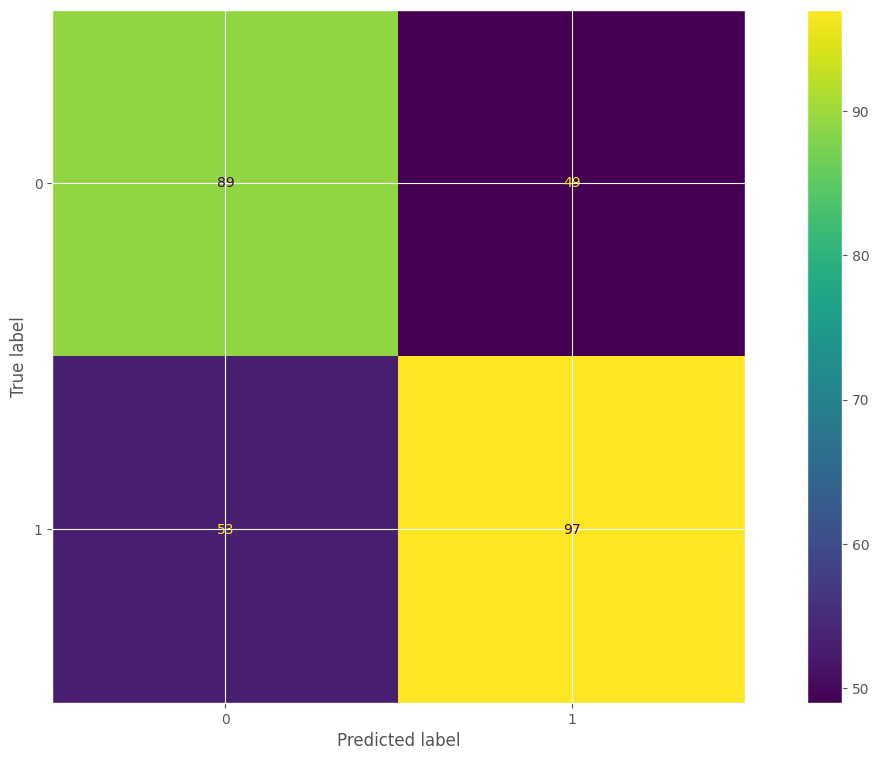

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()


También se puede usar la predicción del conjunto para calcular cualquier otra métrica que necesitemos.

In [29]:
# Muestra un resumen de las métricas de evaluación del modelo
print(classification_report(y_validation, pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       138
           1       0.66      0.65      0.66       150

    accuracy                           0.65       288
   macro avg       0.65      0.65      0.65       288
weighted avg       0.65      0.65      0.65       288



EJERCICIO: crea un modelo considerando 7 vecinos y calcula sus métricas. ¿Ha mejorado en cuanto a *accuracy*? ¿y su *recall* y *precision*?

In [30]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

pred = knn.predict(X_validation)

print(classification_report(y_validation, pred))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       138
           1       0.65      0.67      0.66       150

    accuracy                           0.64       288
   macro avg       0.63      0.63      0.63       288
weighted avg       0.64      0.64      0.64       288



RESPUESTA: Al incrementar el número de vecinos de 5 a 7, el modelo K-NN mantiene un rendimiento muy similar, o incluso algo peor, ya que la accuracy disminuye ligeramente (de 0.65 a 0.64).
También disminuye el recall a la hora de detectar los vinos malos (clase 0), aunque si que se observa una ligera mejora en el recall para los vinos buenos.
La precisión se ve ligeramente disminuida para ambas clases.
En general, el modelo con 7 vecinos es un poco más sensible a la clase positiva, pero empeora ligeramente en el resto. Por lo tanto, no se observa una mejora en el desempeño global frente al modelo con 5 vecinos.

EJERCICIO: repite el proceso ahora para k=3 y contesta a las mismas preguntas teniendo en cuenta los dos modelos anteriores (el de k=5 y el de k=7). ¿Ha mejorado en cuanto a *accuracy*? ¿y su *recall* y *precision*?

In [31]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

pred = knn.predict(X_validation)

print(classification_report(y_validation, pred))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       138
           1       0.70      0.67      0.68       150

    accuracy                           0.68       288
   macro avg       0.68      0.68      0.68       288
weighted avg       0.68      0.68      0.68       288



RESPUESTA: Al reducir el número de vecinos a 3, el modelo mejora ligeramente tanto en accuracy como en precisión y recall respecto a los valores de los modelos anteriores.

EJERCICIO: ¿Cuál de las tres configuraciones es mejor? ¿por qué? Asegúrate que estás evaluando en el conjunto de datos correcto, para poder tomar una decisión.

**NOTA:** La configuración que determines como la mejor, será la que uses el resto de la práctica.

RESPUESTA: dado que hemos obtenido el mejor resultado con la configuración de 3 vecinos (aunque ligera, existe una mejora tanto en accuracy como en precisión y recall), se asume que esta configuración es la mejor.

Una manera de saber cuál es la k que mejor modelo genera, es aplicar el modelo a un rango de k, y ver cual es el resultado que sale para cada una de esas k, y quedarnos con aquella que obtenga el mejor valor.


EJERCICIO EXTRA: implementa un bucle que recorra de 1 a 30 los valores de k.
Crea una gráfica que represente estos valores dónde el eje x sea los valores de k y el eje y el valor de la accuracy obtenido con ese valor.
¿Qué valor de k elegirías para crear el modelo definitivo basándote en la *accuracy*? ¿por qué?

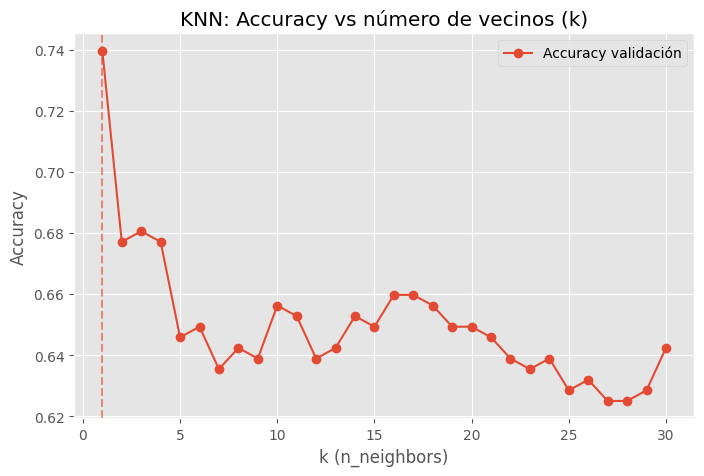

In [32]:
k_values = range(1, 31)
acc_val=[]

for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  acc_val.append(knn.score(X_validation, y_validation))

best_idx = int(np.argmax(acc_val))
best_k = k_values[best_idx]

plt.figure(figsize=(8,5))
plt.plot(k_values, acc_val, marker='o', label='Accuracy validación')
plt.axvline(best_k, linestyle='--', alpha=0.6)
plt.title('KNN: Accuracy vs número de vecinos (k)')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

RESPUESTA: A partir del gráfico, el valor de k que maximiza la accuracy en validación es k = 1, con una precisión aproximada del 74%.
Sin embargo, un valor tan bajo puede provocar sobreajuste, ya que el modelo se adapta demasiado a los datos de entrenamiento.
Por tanto, optaría por un valor más estable como k = 3, que obtiene la segunda accuracy más alta pero con mejor capacidad de generalización a nuevos datos.

EJERCICIO EXTRA: Por defecto *KNeighborsClassifier* usa la distancia euclidea para calcular la distancia entre las instancias. Prueba con la distancia Manhattan, ¿vale el mismo valor de k que has seleccionado antes? ¿por qué? ¿cuál es la mejor accuracy que se obtiene?

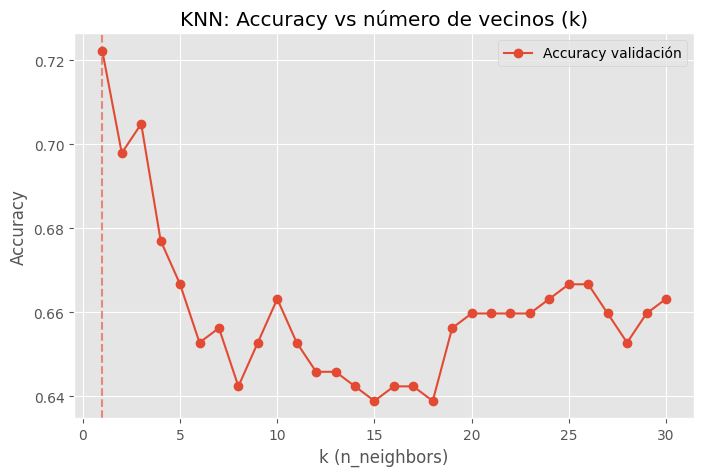

In [33]:
k_values = range(1, 31)
acc_val=[]

for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train, y_train)
  acc_val.append(knn.score(X_validation, y_validation))

best_idx = int(np.argmax(acc_val))
best_k = k_values[best_idx]

plt.figure(figsize=(8,5))
plt.plot(k_values, acc_val, marker='o', label='Accuracy validación')
plt.axvline(best_k, linestyle='--', alpha=0.6)
plt.title('KNN: Accuracy vs número de vecinos (k)')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

RESPUESTA: de nuevo, la mejor precisión se obtiene con k=1 y la siguiente mejor con k=3, por lo que si volvemos a evitar k=1 por el riesgo al sobreajuste, tenemos que el número de vecinos óptimo es el mismo de antes: 3. Cabe destacar que aunque sea el mismo número de vecinos, la precisión obtenida ha sido mejor en el caso de la distancia Manhattan en comparación con la distancia Euclídea.

EJERCICIO EXTRA (si has realizado los ejercicios extra): después de lo visto hasta ahora completa los siguientes parámetros con la mejor opción que consideres para este problema:



*   valor de k:
*   tipo de distancia:

NOTA: Si haces los ejercicios extra, quédate con la mejor configuración para el modelo entre todas (incluidas estas) para realizar el resto de la práctica.




In [37]:
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train, y_train)

pred = knn.predict(X_validation)

print(classification_report(y_validation, pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70       145
           1       0.69      0.72      0.71       143

    accuracy                           0.70       288
   macro avg       0.70      0.70      0.70       288
weighted avg       0.70      0.70      0.70       288



RESPUESTA: por lo visto anteriormente, la mejor precisión se obtiene con k=1 (concretamente con la distancia Euclídea), pero por evitar el sobreajuste, tomaremos el siguente mejor, que en vista de los resultados obtenidos, es:
- valor de k: 3
- tipo de distancia: Manhattan

## Evaluación (parte II)

Vamos a seguir con la evaluación del modelo, como podrás ver las decisiones que se van tomando influyen en los pasos siguientes y la evaluación de la métrica final puede llevar a cambiar alguna de las decisiones tomadas al principio. Por eso es importante ir tomando decisiones y llevándolas acabo de manera ordenada.


A partir de ahora cuando creemos un modelo vamos a trabajar con los parámetros del modelo k-NN que has elegido en el apartado anterior.

EJERCICIO: hasta este momento la partición que hemos hecho del conjunto de training y de testing ha sido de un 90-10% respectivamente, y del conjunto de entrenamiento usando un 80-20%, quedando el 20% para validar.

Calcula la *accuracy* para el mismo conjunto de test que antes, pero ahora entrenando el modelo k-NN con la configuración escogida en el apartado anterior y un reparto del conjunto de entrenamiento de validación, en primer lugar del 90-10% y luego del 75-25%

Teniendo en cuenta la accuracy obtenida también con el reparto 80-20%, ¿cuál es la partición que ha obtenido mejor *accuracy*? ¿por qué crees que es?

NOTA: esta comparación es válida ya que se evalua todo el rato sobre el mismo conjunto de test.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234, shuffle = True) #se puede usar determinando el tamaño del conjunto de train "train_size"

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=1234,shuffle = True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test=scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train, y_train)

pred = knn.predict(X_validation)

print(classification_report(y_validation, pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       173
           1       0.73      0.79      0.76       187

    accuracy                           0.74       360
   macro avg       0.74      0.74      0.74       360
weighted avg       0.74      0.74      0.74       360



RESPUESTA: han mejorado tanto la accuracy como el recall y la precision, por lo que podemos afirmar que esta distribución del conjunto nos ofrece un mejor resultado.

### Validación Simple

Es el método más sencillo consiste en dividir aleatoriamente las observaciones disponibles en dos grupos, uno se emplea para entrenar al modelo y otro para evaluarlo. Se realiza como hemos visto hasta este punto.

Para los siguientes métodos de validación vamos a dividir nuestros datos, únicamente en dos conjuntos (train-test (80-20%)), ya que es el propio método el que se encarga de hacer los conjuntos de validación.

In [39]:
#creamos los conjuntos de entrenamiento y testeo (80-20%)
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                        train_size   = 0.8, #se puede usar determinando el tamaño del conjunto de test "test_size"
                                        random_state = 50,
                                        shuffle      = True
                                    )

### Leave One Out Cross-Validation (LOOCV)

El método LOOCV en un método iterativo que se inicia empleando como conjunto de entrenamiento todas las observaciones disponibles excepto una, que se excluye para emplearla como validación.

El método que vamos a usar es *LeaveOneOut* que se encuentra en la librería *Scikit-Learn* dendro del módulo *model_selection*.

In [40]:
from sklearn.model_selection import LeaveOneOut

Creamos el procedimiento para realizar el método interativo LOOCV

In [41]:
# crear el procedimiento loocv
loocv = LeaveOneOut()

La función *get_n_splits* nos muestra el número particiones (iteraciones) que ha hecho (n-1 muestras para train y 1 para validar). En este caso siempre ha de coincidir con el número de instancias de la muestra.

In [42]:
loocv.get_n_splits(X)

1599

Al llamar a la función *split* del procedimiento *loocv* lo que devuelve son los índices de las estancias que van a ser usadas para entrenar, y el índice de instancia que va a ser usada para testear.
De esta manera podemos recorrer todas las opciones posibles usando un bucle for de la siguiente manera:

In [43]:
for train_index, test_index in loocv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   1    2    3 ... 1596 1597 1598] TEST: [0]
TRAIN: [   0    2    3 ... 1596 1597 1598] TEST: [1]
TRAIN: [   0    1    3 ... 1596 1597 1598] TEST: [2]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [3]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [4]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [5]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [6]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [7]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [8]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [9]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [10]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [11]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [12]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [13]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [14]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [15]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [16]
TRAIN: [   0    1    2 ... 1596 1597 1598] TEST: [17]
TRAIN: [   0    1    2 ... 1596 1597 1

Creamos dentro del bucle cada uno de los conjuntos necesarios para poder aplicar luego un modelo *Xtrain, Xtest, ytrain, ytest*.

In [44]:
for train_index, val_index in loocv.split(X):
  # añadimos cada instancia a su conjunto a través de los índices
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]
  print(X_train, X_val, y_train, y_val)

Se han truncado las últimas 5000 líneas del flujo de salida.
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  
0         9.4  
1         9.8  
2         9.8  
3         9.8  
4         9.4  
...       ...  
1594     10.5  
1595     11.2  
1596     11.0  
1597    

Para ver la estructura de uso completa de este sistema de validación, vamos a usar el algoritmo k-nn con los parámetros elegidos. Para ello completa el siguiente código con modelo que hayas determinado.

In [46]:
#creamos dos variables que son listas vacías para poder ir guardando la clase verdadera de cada instancia y su valor predicho
#y_true, y_pred = list(), list()
y_true=[]
y_pred= []
for train_index, val_index in loocv.split(X):
  # añadimos cada instancia a su conjunto a través de los índices
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]
  # crear el modelo
  model = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
  model.fit(X_train, y_train)
	# testear el modelo
  yhat = model.predict(X_val)
	# almacenar los datos predichos y los datos que conocemos
  y_true.append(y_val.values[0])
  y_pred.append(yhat[0])


EJERCICIO: ¿Cuál será la dimensión de las variables *y_true* e *y_pred*?
Compruébalo.

RESPUESTA: la dimensión será igual al número de instancias, ya que se introduce una por iteración

In [49]:
print("y_true: ", len(y_true))
print("y_pred: ", len(y_pred))

y_true:  1599
y_pred:  1599


En este caso para calcular la *accuracy* vamos a usar el método *accuracy_score* que se encuentra dentro del módulo *metrics* de la librería Scikit-Learn.

In [50]:
from sklearn.metrics import accuracy_score
# calcular accuracy
acc = accuracy_score(y_true, y_pred) #comparamos el valor real con las predicciones
print('Accuracy: %.3f' % acc)

Accuracy: 0.700


EJERCICIO: ¿qué explicación le das al valor de *accuracy* obtenido? No pierdas este valor de vista que lo compararemos con el resto de estrategias de validación.

RESPUESTA: esto significa que, en promedio, el modelo KNN con k=3 y distancia Manhattan acierta el 70 % de las veces cuando se evalúa con esta validación (usando todas las instancias menos una para entrenar y la restante para validar, iterando para todas las instancias). Cabe destacar que es algo mejor que el resultado obtenido previamente.

###k-fold Cross Validation

El método *k-Fold Cross-Validation* es también un proceso iterativo. Consiste en dividir los datos de forma aleatoria en k grupos de aproximadamente el mismo tamaño, k-1 grupos se emplean para entrenar el modelo y uno de los grupos se emplea como validación. Este proceso se repite k veces utilizando un grupo distinto como validación en cada iteración. El proceso genera k estimaciones del error cuyo promedio se emplea como estimación final.

Cargamos las librerías que vamos a necesitar.

In [51]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

Un buen valor para el número de repeticiones depende del conjunto de datos y del ruido que contenga. Se suelen usar valores de 3, 5 o 10 repeticiones probablemente sea un buen comienzo. Probablemente no se requieran más repeticiones de 10.

Vamos a probar con k=5 para empezar. Completa el siguiente código para el modelo kNN y los parámetros que has escogido.

Fíjate en que la *accuracy* que se observa es la media de las *accuracies* obtenidas en cada iteración.

In [52]:
# preparar el procedimiento de cross-validation
cv = KFold(n_splits=5)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
# evaluar el modelo
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.615 (0.036)


EJERCICIO: mira en la ayuda del método kFold si por defecto esta estrategia de validación mezcla las muestras en cada iteración. Prueba lo contrario a lo que ocurra por defecto y dí si influye en el resultado que los datos estén mezclados o no.

In [54]:
help(KFold)

Help on class KFold in module sklearn.model_selection._split:

class KFold(_UnsupportedGroupCVMixin, _BaseKFold)
 |  KFold(n_splits=5, *, shuffle=False, random_state=None)
 |
 |  K-Fold cross-validator.
 |
 |  Provides train/test indices to split data in train/test sets. Split
 |  dataset into k consecutive folds (without shuffling by default).
 |
 |  Each fold is then used once as a validation while the k - 1 remaining
 |  folds form the training set.
 |
 |  Read more in the :ref:`User Guide <k_fold>`.
 |
 |  For visualisation of cross-validation behaviour and
 |  comparison between common scikit-learn split methods
 |  refer to :ref:`sphx_glr_auto_examples_model_selection_plot_cv_indices.py`
 |
 |  Parameters
 |  ----------
 |  n_splits : int, default=5
 |      Number of folds. Must be at least 2.
 |
 |      .. versionchanged:: 0.22
 |          ``n_splits`` default value changed from 3 to 5.
 |
 |  shuffle : bool, default=False
 |      Whether to shuffle the data before splitting int

RESPUESTA: por defecto no se mezclan las muestras

In [70]:
# preparar el procedimiento de cross-validation
cv = KFold(n_splits=5, shuffle=True)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
# evaluar el modelo
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.685 (0.013)


RESPUESTA: el resultado obtenido es muejor en accuracy, además de que la desviación es menor, luego el hecho de que los datos estén mezclados sí influye en el resultado, y de forma positiva.

### Repeticiones de k-fold Cross Validation

Es exactamente igual al método *k-Fold-Cross-Validation* pero repitiendo el proceso completo n veces. Por ejemplo, *10-Fold-Cross-Validation* con 5 repeticiones implica a un total de 50 iteraciones ajuste-validación, pero no equivale a un *50-Fold-Cross-Validation*.

La método que se necesita forma parte de *sklearn.model_selection* y se llama *RepeatedKFold*.

In [56]:
from sklearn.model_selection import RepeatedKFold

EJERCICIO: busca en la ayuda de la librería y completa el siguiente código para obtener la *accuracy* de una *10-Fold-Cross-Validation*. Completa el siguiente código para el modelo kNN y los parámetros que has escogido.

In [58]:
# preparar el procedimiento de cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
# crear el modelo
model =KNeighborsClassifier(n_neighbors=3, metric='manhattan')
# evaluar el modelo
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.692 (0.036)


### Stratified k-fold Cross Validation

Statified K-fold es una variante mejorada de K-fold, que cuando hace los *splits* (las divisiones) del conjunto de train tiene en cuenta mantener equilibradas las clases. Esto es muy útil, porque si por ejemplo tenemos que clasificar en “SI/NO” y una de las iteraciones del K-fold  tuviera muestras con etiquetas sólo “SI” el modelo no podría aprender a generalizar y aprendería que para cualquier entrada hay que responder “SI”.

El método a utilizar se llama *StratifiedKFold* y se encuentra en *sklearn.model_selection*.


EJERCICIO: Crea el código siguiendo el mismo esquema que hasta ahora usando un *Stratified-10-Fold*, usa el modelo kNN con los parametros que has predeterminado, y calcula su *accuracy*.

Recuerda, que en el caso de que la mezcla de los datos no se haga por defecto, es recomendable hacerla.

In [75]:
from sklearn.model_selection import RepeatedStratifiedKFold

# preparar el procedimiento de cross-validation
# Nota: no hay que activar la mezcla de datos porque ya viene por defecto
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
# crear el modelo
model =KNeighborsClassifier(n_neighbors=3, metric='manhattan')
# evaluar el modelo
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.694 (0.034)


### Shuffle Split

Esta estrategia es muy parecida a la ya utilizada *train_test_split*.


EJERCICIO EXTRA: lee en que se diferencia del resto y como se usa. Desarrolla un ejemplo como los hechos hasta ahora dónde uses este método y calcules la *accuracy* para el modelo kNN.

RESPUESTA: ShuffleSplit realiza particiones aleatorias independientes de los datos en train/test. A continuación un ejemplo

In [80]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

model = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('ShuffleSplit - Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

ShuffleSplit - Accuracy: 0.677 (0.026)


EJERCICIO: En la sección kNN de esta práctica has fijado unos parámetros óptimos para el modelo kNN, escríbelos de nuevo:


*   n_neighbors=3
*   metric='manhattan'

Para ese modelo has probado las distintas estrategias de validación.
De todas las estrategias vistas, ¿cuál es la que mejor resultado en términos de *accuracy* ha dado a la hora de comprobar el conjunto de validación? ¿Cuáles son los parámetros que has usado? Indica el valor de *accuracy*.

RESPUESTA: la mejor accuracy se ha obtenido con el método de LOOCV, con un valor de 0.7.

## Evaluación (parte III)

### Métricas

En este apartado vamos a ver cómo obtener las distintas métricas de evaluación.

En lugar de usar el problema anterior como un problema de clasificación binario, vamos a volver a cargarlo y usar la variable objetivo 'quality' sin agrupar, dejando así un problema de clasificación multiclase.

Como hemos visto en teoría, el caso de la clasificación binaria es un caso particular de la clasificación multiclase, por eso vamos a ver las métricas para un problema de este tipo.

Volvemos a cargar el conjunto de datos para empezar de nuevo.

In [ ]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')

Es una buena costumbre, echar un vistazo siempre, y antes de empezar a nuestros datos.

EJERCICIO: Completa el código

In [ ]:
# Mostrar las 10 primeras filas del dataset
# ................
# Comprobamos la dimensión del dataset
# ................
# Obtenemos el tipo de cada una de sus features
# ................

Recuerda que hay que separar el conjunto de datos por un lado tiene que estar la variable con todas las características y por otro, la variable objetivo, en este caso es la variable 'quality'.

EJERCICIO: Completa el código

In [ ]:
#creamos una variable X que tendrá las características de nuestros datos menos la variable objetivo
# ................
#creamos una variable y que tendrá sólo la variable objetivo
# ................

Crea el conjunto de entrenamiento y test dejando un 80-20% respectivamente en cada conjunto. No vamos a partir en uno de validación ya que no vamos a realizar un estudio de hiperparámetros del modelo.

EJERCICIO: Completa el código

In [ ]:
#creamos los conjuntos de entrenamiento y testeo (80-20%)
# ................

En el rápido vistazo que hemos visto de la cabecera de nuestro conjunto de datos, hemos podido apreciar que la escala de las distintas características no es la misma, así que es recomendable escalar los datos. Para ello vamos a estandarizar ("normalizar") los datos haciendo que su media sea 0 (centrándolos en 0) y con una desviación estándar de 1.

Reucerda que has de escalar primero el conjunto de train y luego con la escala utilizada en ese conjunto aplicarlo al conjunto de test.

EJERCICIO: Completa el código

In [ ]:
# Escala los conjuntos de train y test centrandolos en 0 y obteniendo una desviación estándar de 1
# ................

Para empezar vamos a usar el modelo kNN con todos sus parámetros con los valores por defecto.

Obtén la predicción para el conjunto de test.

EJERCICIO: Completa el código

In [ ]:
# Creamos el modelo
knn = KNeighborsClassifier()
# ................

In [ ]:
# Obtenemos la predicción sobre el conjunto de test
# ................

Dentro de la librería *sklearn.metrics* está el método *confusion_matrix* que nos devuelve la **matriz de confusión**. Los parámetros de este método son los valores reales y los valores que se han predicho.

In [ ]:
# Muestra la matriz de confusión
#.................

Cómo se ha visto antes los propios modelos tienen un método que se llama *score* que devuelve la ***accuracy*** (1).

Esta métrica también se puede obtener a partir de la librería *sklearn.metrics* usando *accuracy_score* (2).

In [ ]:
# (1) Obtener la accuracy del conjunto de test usando el método del modelo
knn.score(X_test, y_test)

In [ ]:
# (2) Obtener la accuracy del cjto de test usando sklearn.metrics
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

Si usamos el método *accuracy_score* podemos, además, ver el número de instancias bien clasificadas si ponemos el parámetro *normalize* a falso.

In [ ]:
accuracy_score(y_test, y_pred,normalize=False)

EJERCICIO: Nuestro problema, como hemos dicho es un problema multiclase, fijándote en la matriz de confusión, ¿encuentras razonado la *accuracy* que sale? ¿Por qué?

Hay distintas maneras de obtener las métricas ***recall, precision y F1-score***. Veamos dos de ellas. La primera es obtener las métricas de manera independiente.

Recuerda que para los problemas de clasificación multiclase estas métricas pueden ser calculadas como la media de las métricas de cada clase (**micro**), tenidas en cuenta todas juntas como conjunto (**macro**), o teniendo en cuenta el número de instancias de cada clase para darles un peso (**weighted**).

Fíjate en el siguiente código. Los métodos que vamos a usar están en la librería [*sklearn.metrics*](https://scikit-learn.org/stable/modules/model_evaluation.html); es importante especificar en el parámetro *average* cuál es la estrategia a seguir para calcular cada uno.

EJERCICIO: Completa el código para calcular el resto de métricas.


In [ ]:
#importar los métodos que necesitamos precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(#..................................))
print('Macro Recall: {:.2f}'.format(#..................................))
print('Macro F1-score: {:.2f}\n'.format()#..................................))

print('Weighted Precision: {:.2f}'.format(#..................................))
print('Weighted Recall: {:.2f}'.format(#..................................))
print('Weighted F1-score: {:.2f}'.format(#..................................))

Otra manera de obtener las métricas, es recogerlas como un informe usando el método *classification_report*

In [ ]:
from sklearn.metrics import classification_report
target_names = ['3 level', '4 level', '5 level', '6 level','7 level','8 level']
print(classification_report(y_test, y_pred, target_names=target_names))

Para calcular el *área bajo la curva* (***auROC***) hay que tener en cuenta si nuestro problema es de clasificación binaria, multiclase o multietiqueta. En cualquier caso se puede calcular pero teniendo en cuenta ciertas restricciones (más info [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score))

El problema de este ejemplo es un problema multiclase así que vamos a calcular el *auROC* utilizando el método *roc_auc_score* especificando como queremos que sea el estudio de las clases. Principalmente hay dos estrategias:

*    'ovr' (*one-vs-rest*): calcula la *auROC* de cada clase contra el resto
*     'ovo' (*one-vs-one*): calcula la media de las *auROC* de todas las posibles combinaciones por pares de las clases.

A continuación vemos el ejemplo de uso de este método y los resultados obtenidos.

Para ello en lugar de calcular las predicciones es necesario calcular la probabilidad que tiene cada instancia de pertenecer a una clase. De hecho la mayor de las probabilidades es la que marca a que clase va a pertenecer la instancia.

Para ello hay que usar el método *predict_proba* del propio modelo.

In [ ]:
y_prob=knn.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

EJERCICIO EXTRA: Antes has determinado una configuración óptima para el problema de clasificación binaria (la clase objetivo era "good" o "bad"). Comprueba si esa misma configuración mejora el resultado obtenido con los parámetros por defecto usados antes, para el problema de clasificación multiclase que tenemos ahora, crea el modelo y obtén su matriz de confusión y su *accuracy*.

EJERCICIO EXTRA: vuelve a obtener un problema de **clasificación binario** separando la variable objetivo en dos clases "good" y "bad" como hemos hecho antes.

Para el método kNN con los parámetros seleccionados como los más óptimos y usando la estrategia de validación que has elegido como la mejor, calcula la matriz de confusión, y las métricas recall, precision, F1-score y el valor de auROC y su gráfica.

Reescribe todo lo que necesites para que quede el proceso de manera ordenada y legible (se puntuará positivamente), a continuación tienes una nota dónde puedes ver todas las partes del flujo de trabajo típico de un problema de *Machine Learning* y que debería verse reflejado en este ejercicio.




### Nota

El último ejercicio propuesto es un ejemplo de un proceso completo de aplicación de un método de aprendizaje supervisado. Repasando el flujo de trabajo nos quedaría algo así:


*   **"Identificar el problema:"** queremos predecir la calidad del vino (good o bad) en función de una serie de características de éste.
*   **"Obtener los datos: compilar preparar"**: observamos como son los datos que tenemos y en este caso los escalamos centrandolos en 0 y dejando una desviacion estándar de 1
*   **"Modelar y procesar los datos"**: utilizamos una estrategia de validación para obtener el mejor modelo. Lo obtenemos y lo usamos para predecir el conjunto de test.
*   **"Evaluar e interpretar los datos"**: usamos las métricas de evaluación para comprobar como es de óptimo nuestro modelo y si se obtiene un nivel de los resultados asumible por el problema planteado.

## Resumen modelos

EJERCICIO: Una vez hecho los ejercicios, completa la siguiente tabla para tener de manera fácil la comparación entre los distintos modelos utilizados. Esta tabla deberás completarla a lo largo del resto de prácticas.

NOTA: puedes completar la tabla con tantas columnas o filas como consideres.

In [ ]:
import pandas as pd
import numpy as np

colum=["dataset","balanceo?","técnica balanceo","escalar","algoritmo","parámetros","accuracy"]

# Crear una tabla
data = np.array([['ej_wine','si','downsampling','minmax','knn','k=7','0.91']])

pd.DataFrame(data, columns=colum)

## Data Leakage

Al aplicar algunas de las estrategias de validación, hay que tener en cuenta que si el conjunto de datos requiere de una normalización o estandarización, en definitiva de un preprocesado esto se tiene que hacer para el conjunto de entrenamiento, y luego aplicar las mismas reglas al conjunto de validación y/o test.

Un problema derivado de no tratar bien los datos en los diferentes conjuntos, es el conocido como Data Leakage, dónde el conocimiento del conjunto de test y/o validación se filtra al conjunto de datos utilizado para entrenar el modelo. Puedes encontrar más información sobre este problema y como se resuelve [aquí](https://machinelearningmastery.com/data-preparation-without-data-leakage/).

Esto puede resultar en una estimación incorrecta del rendimiento del modelo al realizar predicciones sobre nuevos datos.

Hay diferentes causas que pueden derivar en data leakage, verlas [aquí](https://towardsdatascience.com/data-leakage-in-machine-learning-how-it-can-be-detected-and-minimize-the-risk-8ef4e3a97562).

Se requiere una aplicación cuidadosa de las técnicas de preparación de datos para evitar la fuga de datos o data leakage, y esto varía según el esquema de evaluación del modelo utilizado (validación simple, cross-validation,...)

Veamos el caso concreto de usar el método de validación [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) y necesitar escalar los datos usando el método [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) de Sklearn.

La idea es que para cada vez que se pruebe el modelo (para cada ‘K’) los datos deberían de escalarse y luego aplicar las reglas sobre el conjunto de validación.

Para poder hacer esto, una forma es "programarlo de manera manual" obteniendo con la técnica de validación las particiones y luego recorriendolas escalando y creando el modelo.

Hay otra forma más sencilla que es usando [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline), en este caso se establecerían 3 pasos:
* Escalar los datos
* Configuración del modelo
* Técnica de validación


Veamos un ejemplo de código, al ejecutar, los datos se escalan dentro de cada iteración de la técnica de validación.

In [ ]:
# Preparación correcta de los datos para evaluar el modelo con una k-fold cross-validation

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
# definir el dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

In [ ]:
X.shape

(1000, 20)

In [ ]:
# definir los pasos que va a tener el pipeline
steps = list()
steps.append(('scaler', MinMaxScaler())) # escalar los datos
steps.append(('model', LogisticRegression())) # configuración del modelo
pipeline = Pipeline(steps=steps) # creación de la secuencia

In [ ]:
# definir el proceso de validación
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # configuración de la técnica de validación
# evaluar el modelo usando cross_val_score
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) # usar cross_val_score, con el pipeline y la técnica de validación
# mostrar el rendimiento del modelo
print('Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))


Accuracy: 85.400 (3.489)
